In [1]:
import os
import torch
torch.cuda.set_device(0)
from video_dataset import image_data
from models import Attentive_VGG
import numpy as np
import torch.nn.utils as utils
import json
import argparse
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.misc import imread, imresize
from torchvision.transforms import ToPILImage
from PIL import Image

is_cuda = torch.cuda.is_available()
base_path = '/home/masiha/Emotion/Faces'

In [2]:
exp = {
    "paper_master":{
    "base_lr": 1e-2, "lrs": [10, 1], "wd": 5e-4, "seeds": [0], "opt": "sgd", "cuda": 5, "shift": False, 
    "eval_fact": 40, "net": "vgg16", "pooling":"softmax", "attention_hop":2, "dropout": 0, "ep": 30,
    "comment" : "with attention",
    "status": "Done 48.8"
    },
    "paper_master_att_1":{
        "base_lr": 1e-2, "lrs": [10, 1], "wd": 5e-4, "seeds": [0], "opt": "sgd", "cuda": 5, "shift": False, 
        "eval_fact": 40, "net": "vgg16", "pooling":"softmax", "attention_hop":2, "dropout": 0, "ep": 30,
        "comment" : "with attention at the end",
        "status": "??"
        },
}
name = "paper_master_att_1"

In [3]:
model = Attentive_VGG(num_classes=7, shift=exp[name]['shift'],
                      weights=os.path.join(base_path, 'models', 'pretrained'), net=exp[name]['net'],
                    pooling=exp[name]['pooling'], attention_hop=exp[name]['attention_hop'],
                    dropout=exp[name]['dropout'])


model.load_state_dict(torch.load(os.path.join(base_path, 'models', 'paper', name + '.pth')))

if is_cuda:
    model.cuda()

model.eval()
_, valid_loader = image_data(path=base_path, num_frames_per_clip=16,
                    bs=3, debug=False, 
                    size=224, num_workers=8, eval_fact=exp[name]['eval_fact'])

idx2class = {k:v for k,v in enumerate(valid_loader.dataset.classes)}

vgg16_att_hop_2_False_softmax


In [9]:
with torch.no_grad():
    for data, target in valid_loader:
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        output, spatial, temporal = model(data)

        if target.item() == output.argmax(dim=-1).item():
            break

data = data.squeeze().cpu()
temporal = temporal.squeeze().cpu().numpy()
spatial_all = spatial.mean(1)
spatial_all = spatial_all.cpu().numpy()
spatial_all = spatial_all.reshape(spatial_all.shape[0], 7, 7)
spatial = spatial.cpu().numpy()
spatial = spatial.reshape(spatial.shape[0], spatial.shape[1], 7, 7)
cls = target.item()
print(target, output.argmax(dim=-1))

tensor([3], device='cuda:0') tensor([3], device='cuda:0')


In [27]:
num_frames = 6
scale = 48

In [54]:
print(np.argsort(temporal[:,cls])[-num_frames:])
print(np.argmax(temporal[:,cls]))

[33 32 23 22 21 20]
20


In [55]:
most_confidants = np.argsort(temporal[:,cls])[-num_frames:]
most_confidants.sort()
most_confidants

array([20, 21, 22, 23, 32, 33])

In [56]:
length = len(most_confidants)

In [57]:
temporal[most_confidants, cls]

array([0.18464366, 0.13440545, 0.12476874, 0.08766262, 0.04818737,
       0.04812036], dtype=float32)

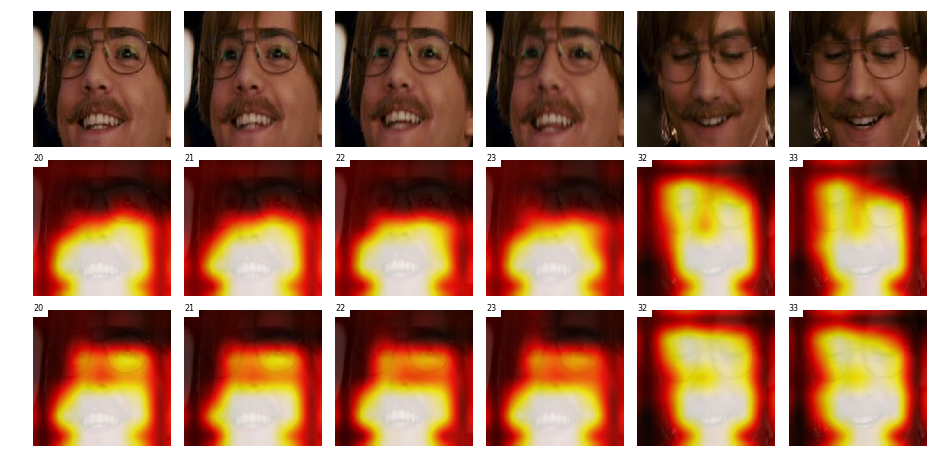

In [105]:
plt.figure(figsize=(16, 8))
# salients = temporal.sum(axis=1)
# maxx = temporal[frames].max(1).max(0)

# for idx, t in enumerate(frames, 1):
    
#     plt.subplot(np.ceil(len(frames) / 10.)*4, 10, idx)
    
#     bars = plt.barh(0, salients[t]*10)
#     bars[0].set_facecolor('g')
#     plt.xlim(0, 1)  
#     plt.ylim(0, 1.5) 
#     plt.axis('off')

for idx, t in enumerate(most_confidants, 1):
    image = ToPILImage()(data[t])
    image = image.resize([7 * scale, 7 * scale], Image.LANCZOS)
    
    plt.subplot(np.ceil(length / num_frames)*3, num_frames, idx + 0*length)    
    plt.imshow(image, aspect='auto')
#     plt.imshow(image)
    
    
    plt.axis('off')

for idx, t in enumerate(most_confidants, 1):
    
    image = ToPILImage()(data[t])
    image = image.resize([7 * scale, 7 * scale], Image.LANCZOS)
    
    plt.subplot(np.ceil(length / num_frames)*3, num_frames, idx + 1*length)
    plt.text(0, 1, f'{t}', color='black', backgroundcolor='white', fontsize=8)
    
    plt.imshow(image, aspect='auto')
#     plt.imshow(image)
    
#     current_alpha = spatial_all[t, :,:]
    current_alpha = spatial[t, 0, :,:]
    alpha = skimage.transform.pyramid_expand(current_alpha, upscale=scale, sigma=8)
    plt.imshow(alpha, alpha=0.8, aspect='auto', cmap='hot')
#     plt.imshow(alpha, alpha=0.4, cmap='gray')
    
    
    plt.axis('off')
    
for idx, t in enumerate(most_confidants, 1):
    
    image = ToPILImage()(data[t])
    image = image.resize([7 * scale, 7 * scale], Image.LANCZOS)
    
    plt.subplot(np.ceil(length / num_frames)*3, num_frames, idx + 2*length)
    plt.text(0, 1, f'{t}', color='black', backgroundcolor='white', fontsize=8)
    
    plt.imshow(image, aspect='auto')
#     plt.imshow(image)
    
#     current_alpha = spatial_all[t, :,:]
    current_alpha = spatial[t, 1, :,:]
    alpha = skimage.transform.pyramid_expand(current_alpha, upscale=scale, sigma=8)
    plt.imshow(alpha, alpha=0.8, aspect='auto', cmap='hot')
#     plt.imshow(alpha, alpha=0.4, cmap='gray')
    
    
    plt.axis('off')
    
# for idx, t in enumerate(frames, 1):

#     plt.subplot(np.ceil(len(frames) / 10.)*4, 10, idx + len(frames)*3)
#     maxx = temporal[frames].max(1).max(0)
#     cls = temporal[t].argmax(axis=-1)
#     x = np.arange(7)
#     bars = plt.bar(x, temporal[t])
#     bars[cls].set_facecolor('r')
#     plt.xticks(x, valid_loader.dataset.classes, rotation='vertical')
#     plt.ylim(0, maxx) 
    
#     ax = plt.gca()
#     ax.get_yaxis().set_visible(False)
#     ax.get_xticklabels()[cls].set_color('red') 

# for idx, t in enumerate(most_confidants, 1):

#     plt.subplot(np.ceil(length / 10.)*3, 10, idx + 2*length)
#     x = np.arange(7)
#     bars = plt.barh(x, temporal[t])
#     bars[cls].set_facecolor('r')
#     if idx == 1:
#         plt.yticks(x, valid_loader.dataset.classes)
        
# #     plt.xlim(0, maxx) 
#     ax = plt.gca()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yticklabels()[cls].set_color('red')
#     if idx > 1:
#         ax.get_yaxis().set_visible(False)

    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [59]:
temporal[most_confidants, cls]

array([0.18464366, 0.13440545, 0.12476874, 0.08766262, 0.04818737,
       0.04812036], dtype=float32)

In [60]:
base = 2
arr = np.log2(temporal[most_confidants, :] + 1) / np.log(base)
arr[:, cls]

array([0.35267133, 0.26247877, 0.24472204, 0.17489946, 0.09795415,
       0.09782111], dtype=float32)

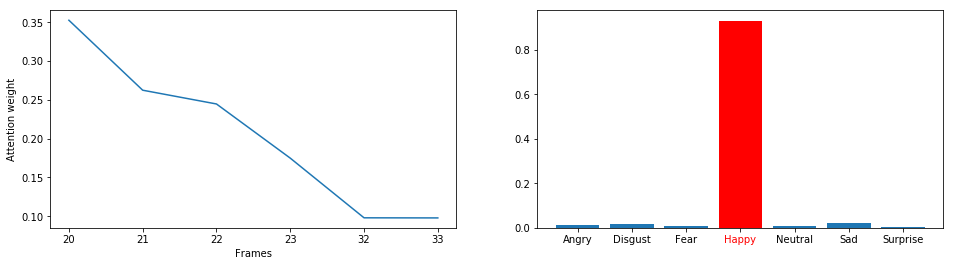

In [106]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(list(range(num_frames)), arr[:,cls])
plt.xticks(list(range(num_frames)), most_confidants)
plt.xlabel('Frames')
plt.ylabel('Attention weight')

plt.subplot(1, 2, 2)
bars = plt.bar(np.arange(7), temporal.sum(0))
bars[cls].set_facecolor('r')
plt.xticks(np.arange(7), valid_loader.dataset.classes)
ax = plt.gca()
ax.get_xticklabels()[cls].set_color('red') 
plt.show()


plt.show()

In [99]:
temporal[most_confidants, :]

array([[4.2826188e-04, 1.5098341e-03, 3.4706877e-06, 1.8464366e-01,
        2.7335262e-05, 5.3841673e-04, 2.0314228e-05],
       [5.4652849e-04, 1.2768619e-03, 4.2671104e-06, 1.3440545e-01,
        3.0277755e-05, 4.4773045e-04, 2.1413418e-05],
       [4.4463458e-04, 1.2452463e-03, 4.6016344e-06, 1.2476874e-01,
        3.1210078e-05, 5.1169668e-04, 2.4191086e-05],
       [6.4098038e-04, 9.5500157e-04, 5.9161935e-06, 8.7662622e-02,
        2.9321700e-05, 4.6933960e-04, 2.4797397e-05],
       [2.0153768e-04, 9.3186001e-04, 4.6813889e-06, 4.8187368e-02,
        5.9700291e-05, 8.8598055e-04, 1.9545712e-05],
       [2.0114071e-04, 9.1651164e-04, 4.5072288e-06, 4.8120365e-02,
        5.1284176e-05, 9.0309279e-04, 1.8859413e-05]], dtype=float32)

In [101]:
temporal[most_confidants, cls]

array([0.18464366, 0.13440545, 0.12476874, 0.08766262, 0.04818737,
       0.04812036], dtype=float32)

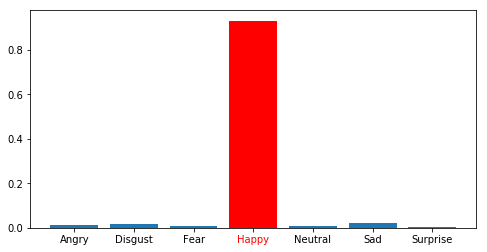

In [89]:
plt.figure(figsize=(8, 4))
bars = plt.bar(np.arange(7), temporal.sum(0))
bars[cls].set_facecolor('r')
plt.xticks(np.arange(7), valid_loader.dataset.classes)
ax = plt.gca()
ax.get_xticklabels()[cls].set_color('red') 
plt.show()

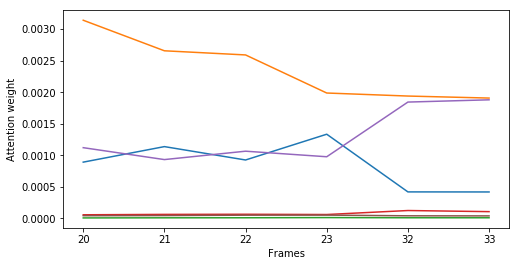

In [70]:
plt.figure(figsize=(8, 4))

for i in range(7):
    if i == cls:
        continue
    else:
        plt.plot(list(range(num_frames)), arr[:,i])
        
# plt.plot(list(range(num_frames)), temporal[most_confidants, 1])
# plt.plot(list(range(num_frames)), temporal[most_confidants, 2])
plt.xticks(list(range(num_frames)), most_confidants)
plt.xlabel('Frames')
plt.ylabel('Attention weight')
plt.show()